# Pipeline Leak Detection - ML Model Training
This notebook loads real-time pipeline sensor data, integrates physics-based features (RTTM, Navier-Stokes), trains a Random Forest model, evaluates it, and exports a `.pkl` file.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
from pykalman import KalmanFilter

# Load dataset
df = pd.read_csv("pipeline_sensor_data.csv")
df.head()


,flow_in,flow_out,pressure_in,pressure_out,temperature_in,temperature_out,density_in,density_out,velocity_variation,vorticity,mass_deviation,energy_loss,gps_segment_id,leak
0,96.428267,93.764522,68.581740,62.115199,50.424187,43.609532,0.851263,0.831550,-0.194937,-0.001102,2.663745,302.291975,5,1
1,103.129287,102.210810,69.671349,68.852768,47.434016,45.690765,0.836434,0.833384,0.019732,0.083725,0.918477,94.807558,1,0
2,99.766468,96.449015,68.227189,62.994402,48.012275,43.262374,0.850444,0.835795,0.075649,-0.015259,3.317453,344.927760,3,1
3,98.571297,97.946727,70.088828,69.065609,52.019634,50.898032,0.847046,0.840703,-0.061636,0.067023,0.624570,82.409602,4,0
4,99.677429,99.181232,70.620152,68.909900,52.216366,51.004621,0.845173,0.837171,-0.118941,0.060597,0.496197,81.054125,17,0


In [133]:
# Physics-enhanced feature engineering for pipeline leak detection (No time column)

# Constants and standard assumptions
f = 0.015  # Darcy-Weisbach friction factor (typical for clean pipes)
bulk_modulus = 2.2e9  # Bulk modulus of water (Pa)
D = 1.0  # Pipe diameter in meters (assumption)
A = np.pi * (D / 2) ** 2  # Cross-sectional area in m²

# Read the CSV file (update path if needed)
df = pd.read_csv("pipeline_sensor_data.csv")  # Replace with your actual file path
leak_label = df['leak'].copy() 
# Derived parameters
rho = (df['density_in'] + df['density_out']) / 2  # Average fluid density

# Step 1: Velocity Calculation
df['v_in'] = df['flow_in'] / (rho * A)
df['v_out'] = df['flow_out'] / (rho * A)

# Step 2: Advanced Mass Conservation
df['dm_dt'] = df['flow_in'].diff() - df['flow_out'].diff()

# Step 3: Momentum Equation (simplified RTTM)
df['momentum_loss'] = (
    df['v_out'].diff() +
    (df['v_out'] * df['v_out'].diff()) +
    (1 / rho) * df['pressure_out'].diff() +
    f * (df['v_out'].abs() * df['v_out']) / (2 * D)
)

# Step 4: Pressure Wave Speed (compressible fluid approximation)
df['sound_speed'] = np.sqrt(bulk_modulus / rho)

# Step 5: Kalman Filter Smoothing (example on flow_out)
from pykalman import KalmanFilter
kf = KalmanFilter(initial_state_mean=df['flow_out'].iloc[0], n_dim_obs=1)
flow_out_filtered, _ = kf.em(df['flow_out'].values).filter(df['flow_out'].values)
df['flow_out_filtered'] = flow_out_filtered

# Step 6: Flow Prediction Residual (to feed into ML)
df['flow_predicted'] = rho * A * df['v_in']  # Based on velocity-in
df['flow_residual'] = df['flow_out'] - df['flow_predicted']

# Step 7: Advanced Leak Labeling Rule
df['leak'] = (
    (df['dm_dt'].abs() > 2.0) | (df['flow_residual'].abs() > 2.0)
    # (df['momentum_loss'].abs() > 10) |
).astype(int)

# Add the original leak labels back to the dataframe
df['original_leak'] = leak_label

features = ['v_in', 'v_out', 'dm_dt', 'momentum_loss', 'sound_speed', 'flow_out_filtered', 'flow_residual','leak', 'original_leak']
df[features]


,v_in,v_out,dm_dt,momentum_loss,sound_speed,flow_out_filtered,flow_residual,leak,original_leak
0,145.917976,141.887121,NaN,NaN,51133.850614,96.331823,-2.663745,1,1
1,157.272538,155.871857,-1.745268,2384.101518,51332.417847,97.223533,-0.918477,0,0
2,150.662721,145.652856,2.398976,-1346.483466,51081.881467,97.042388,-3.317453,1,1
3,148.724587,147.782235,-2.692883,487.805143,51059.014906,97.294943,-0.624570,1,0
4,150.876741,150.125673,-0.128373,523.001474,51140.976479,97.864792,-0.496197,0,0
...,...,...,...,...,...,...,...,...,...
495,156.060898,155.314528,-0.122734,30.116294,50975.613405,101.206432,-0.496297,0,0
496,150.610844,144.705649,3.435894,-1395.216645,50939.663510,99.642321,-3.932192,1,1
497,151.843028,147.152469,-0.873207,522.268460,51473.059194,98.456633,-3.058984,1,1
498,154.766935,151.104932,-0.671151,775.197080,51477.055174,98.479957,-2.387833,1,1


In [134]:
# Features for the model (based on your derived parameters)
features = ['v_in', 'v_out', 'dm_dt', 'momentum_loss', 'sound_speed', 'flow_out_filtered', 'flow_residual']

# Label for the model (leak detection)
label = 'leak'

# Select the data for training
X = df[features]
y = df[label]


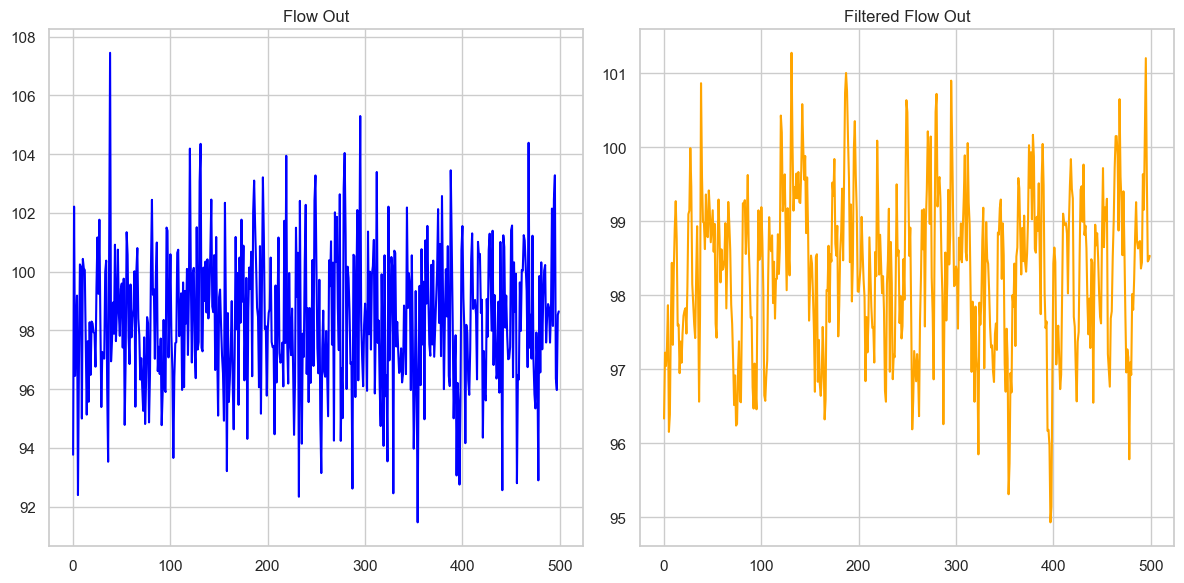

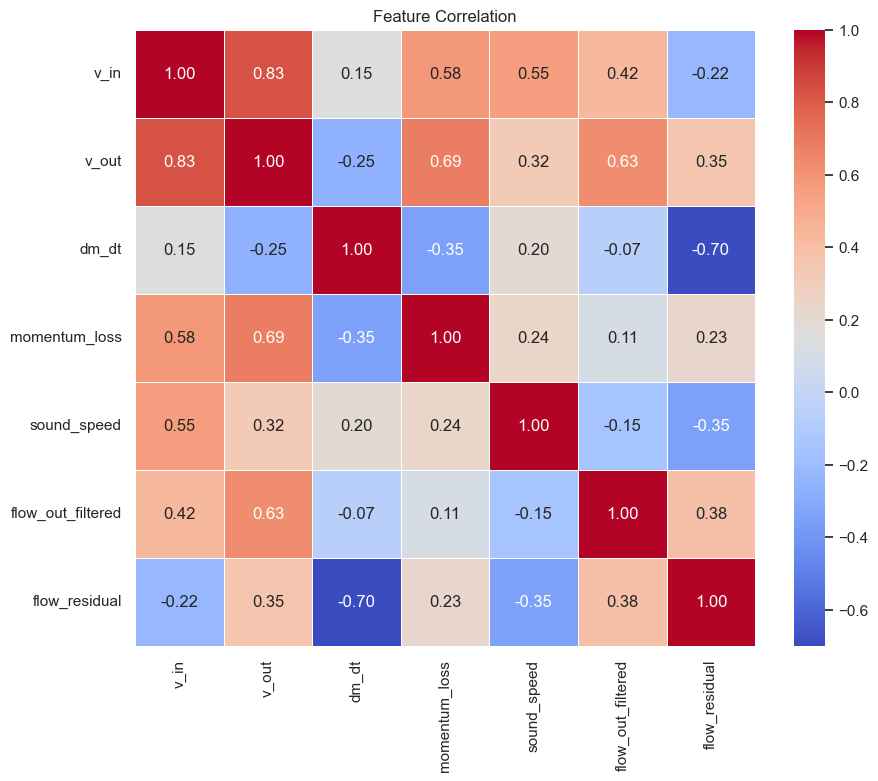

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of flow_out and flow_out_filtered
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df['flow_out'], label='Flow Out', color='blue')
plt.title('Flow Out')
plt.subplot(1, 2, 2)
plt.plot(df['flow_out_filtered'], label='Filtered Flow Out', color='orange')
plt.title('Filtered Flow Out')
plt.tight_layout()
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation')
plt.show()


In [136]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 2: Impute missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Step 3: Apply SMOTE with reduced k_neighbors
smote = SMOTE(random_state=42, k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

# Step 4: Report class distribution
print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_resampled).value_counts())


Before SMOTE:
 leak
1    229
0    171
Name: count, dtype: int64
After SMOTE:
 leak
1    229
0    229
Name: count, dtype: int64


In [137]:
from sklearn.ensemble import RandomForestClassifier

# Optional: Use class_weight='balanced' to handle minor imbalance
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)

# Predict
y_pred = model.predict(X_test)


c:\Users\e019897\Downloads\Lakki Project\pipeline-leak-detection\pipeline-leak-detection\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


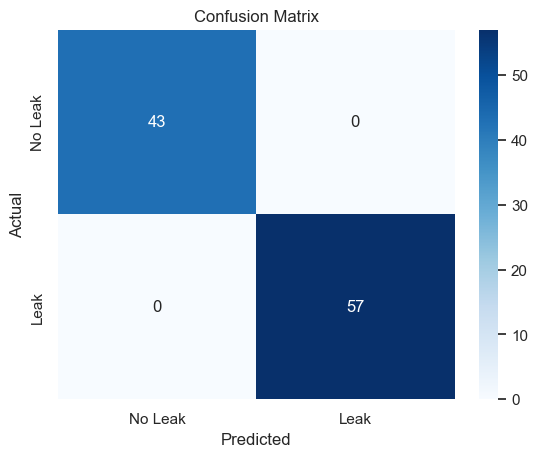

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00        57

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [138]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Leak', 'Leak'], yticklabels=['No Leak', 'Leak'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


In [139]:

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the data
print("Train Features Shape:", X_train.shape)
print("Test Features Shape:", X_test.shape)


Train Features Shape: (400, 7)
Test Features Shape: (100, 7)


In [140]:
# ML Pipeline: Standardization + Random Forest Classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)



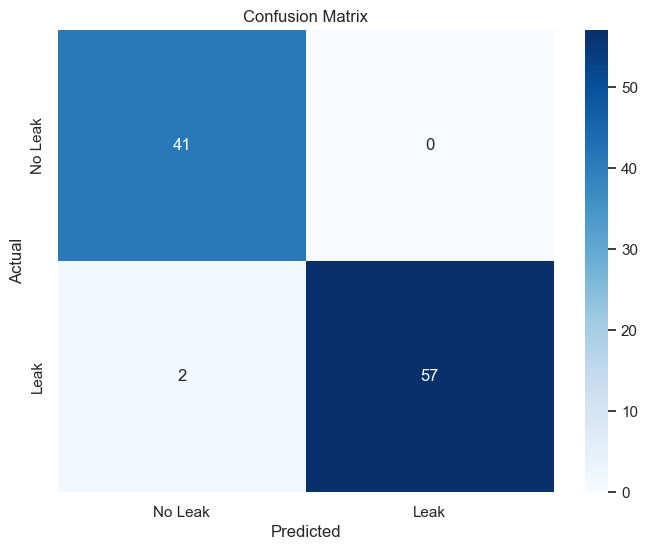

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        41
           1       1.00      0.97      0.98        59

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



In [141]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Leak', 'Leak'], yticklabels=['No Leak', 'Leak'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report for performance metrics
print("Classification Report:\n", classification_report(y_test, y_pred))


In [142]:
from sklearn.metrics import accuracy_score

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 98.00%


In [143]:
import pickle  

# Save the pipeline (model + scaler)
with open('pipeline_leak_detection_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

print("Model saved to 'pipeline_leak_detection_model.pkl'")


Model saved to 'pipeline_leak_detection_model.pkl'


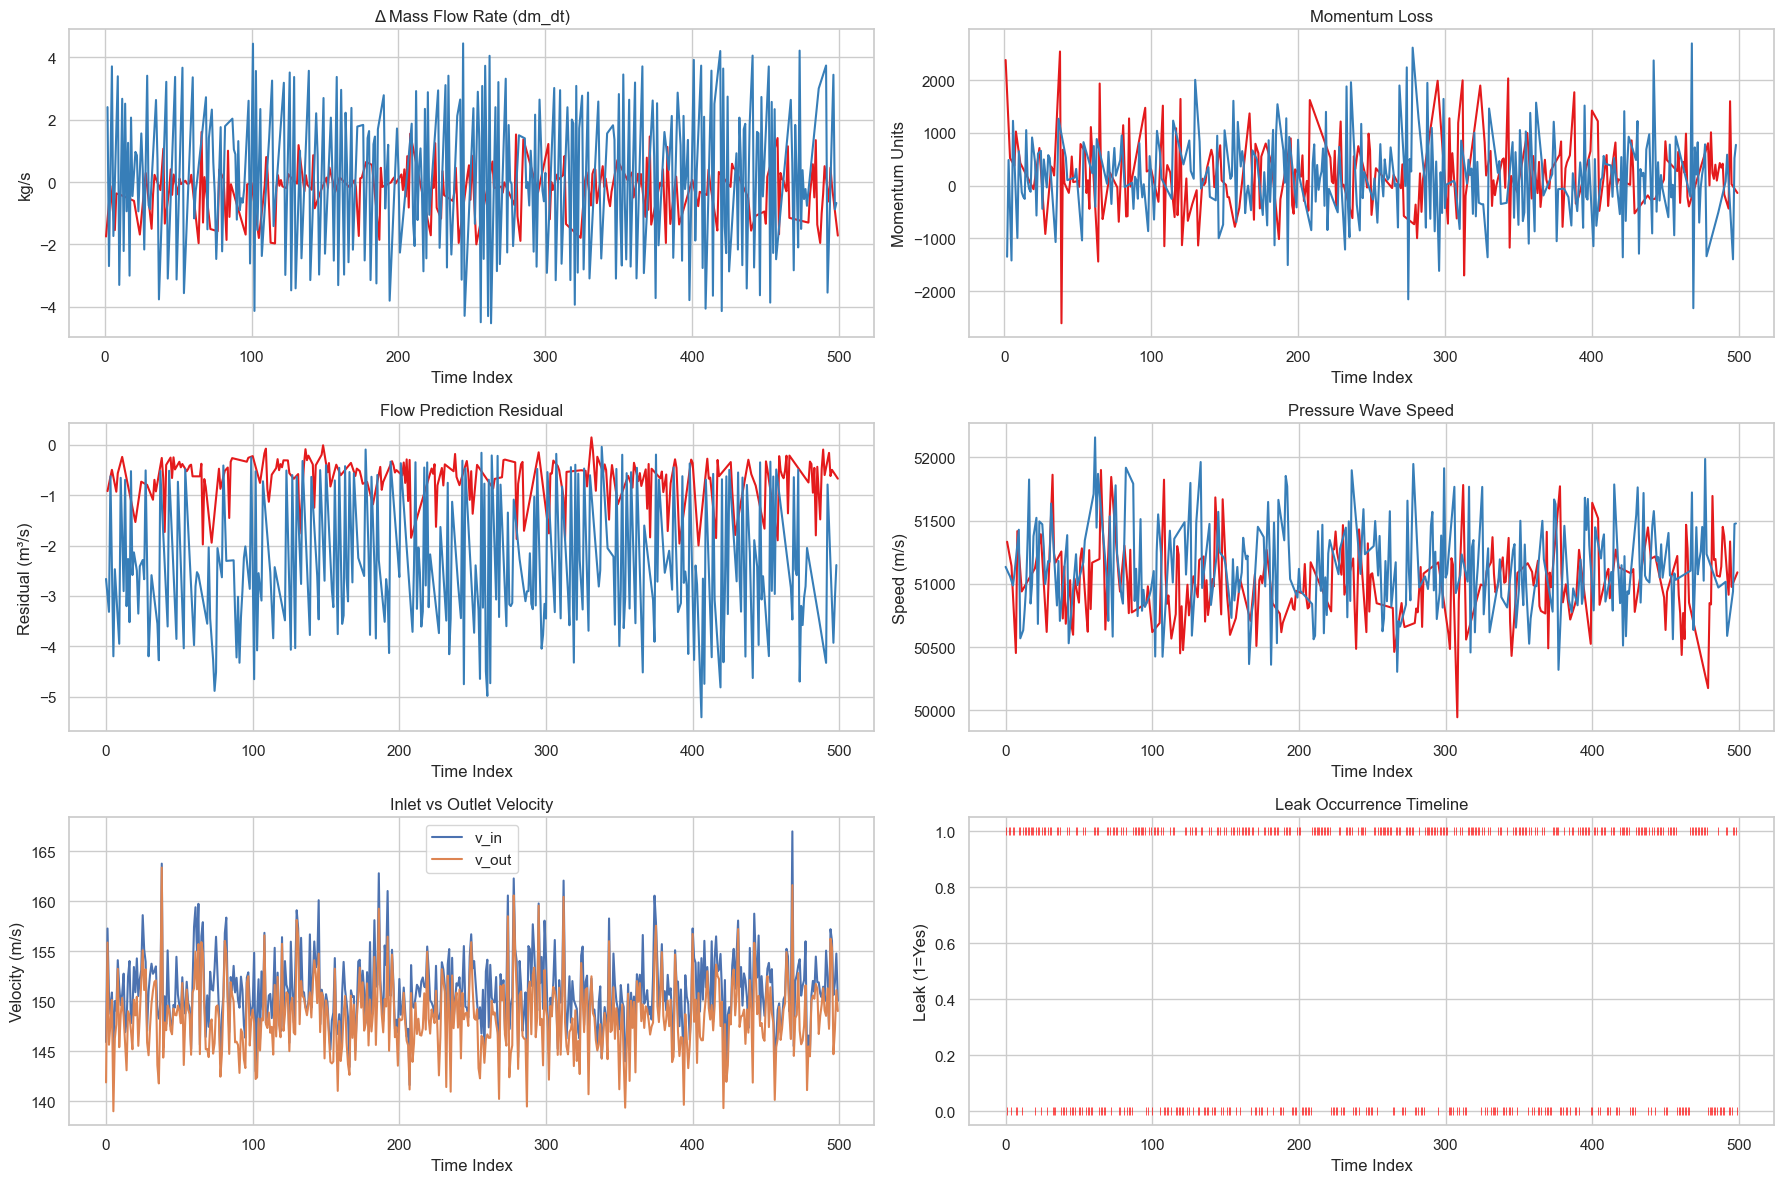

In [144]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(18, 12))

# 1. Mass Flow Derivative
plt.subplot(3, 2, 1)
sns.lineplot(data=df, x=df.index, y='dm_dt', hue='leak', palette='Set1', legend=False)
plt.title("Δ Mass Flow Rate (dm_dt)")
plt.xlabel("Time Index")
plt.ylabel("kg/s")

# 2. Momentum Loss
plt.subplot(3, 2, 2)
sns.lineplot(data=df, x=df.index, y='momentum_loss', hue='leak', palette='Set1', legend=False)
plt.title("Momentum Loss")
plt.xlabel("Time Index")
plt.ylabel("Momentum Units")

# 3. Flow Residual (prediction error)
plt.subplot(3, 2, 3)
sns.lineplot(data=df, x=df.index, y='flow_residual', hue='leak', palette='Set1', legend=False)
plt.title("Flow Prediction Residual")
plt.xlabel("Time Index")
plt.ylabel("Residual (m³/s)")

# 4. Sound Speed
plt.subplot(3, 2, 4)
sns.lineplot(data=df, x=df.index, y='sound_speed', hue='leak', palette='Set1', legend=False)
plt.title("Pressure Wave Speed")
plt.xlabel("Time Index")
plt.ylabel("Speed (m/s)")

# 5. Velocity In vs Out
plt.subplot(3, 2, 5)
sns.lineplot(data=df, x=df.index, y='v_in', label='v_in')
sns.lineplot(data=df, x=df.index, y='v_out', label='v_out')
plt.title("Inlet vs Outlet Velocity")
plt.xlabel("Time Index")
plt.ylabel("Velocity (m/s)")
plt.legend()

# 6. Leak Flag Timeline
plt.subplot(3, 2, 6)
sns.scatterplot(data=df, x=df.index, y='leak', marker='|', color='red')
plt.title("Leak Occurrence Timeline")
plt.xlabel("Time Index")
plt.ylabel("Leak (1=Yes)")

plt.tight_layout()
plt.show()


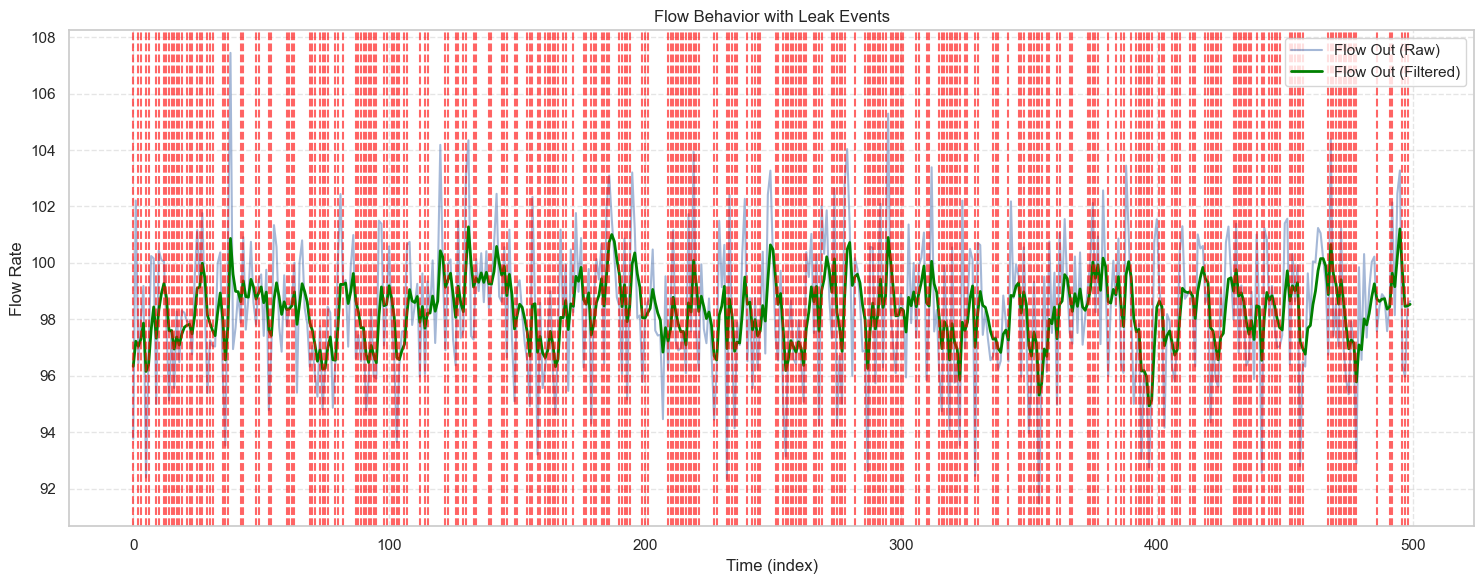

In [145]:
plt.figure(figsize=(15, 6))

# Plot raw and filtered flow_out
plt.plot(df.index, df['flow_out'], label='Flow Out (Raw)', alpha=0.5, linewidth=1.5)
plt.plot(df.index, df['flow_out_filtered'], label='Flow Out (Filtered)', color='green', linewidth=2)

# Plot leak events
leak_indices = df[df['leak'] == 1].index
for leak_idx in leak_indices:
    plt.axvline(x=leak_idx, color='red', linestyle='--', alpha=0.6)

plt.title("Flow Behavior with Leak Events")
plt.xlabel("Time (index)")
plt.ylabel("Flow Rate")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [157]:
import pickle
import pandas as pd

# Step 1: Load the saved model
with open('pipeline_leak_detection_model.pkl', 'rb') as file:
    model = pickle.load(file)

# Step 2: Your new input values (single row)
new_data = {
    'v_in': 158.0,
    'v_out': 158.0,
    'dm_dt': -3.0,
    'momentum_loss': 50.0,
    'sound_speed': 51450.0,
    'flow_out_filtered': 96.5,
    'flow_residual': -1
}

# ✅ Wrap it in a list to form a DataFrame with one row
df_new = pd.DataFrame([new_data])

# Step 4: Predict
predictions = model.predict(df_new)

# Step 5: Add predictions to DataFrame
df_new['predicted_leak'] = predictions

# Step 6: Show result
print(df_new)


    v_in  v_out  dm_dt  momentum_loss  sound_speed  flow_out_filtered  \
0  158.0  158.0   -3.0           50.0      51450.0               96.5   

   flow_residual  predicted_leak  
0             -1               1  
